In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sys.path.append('/Users/willbarnes/Documents/Rice/Research/EBTEL_analysis/src/')
import ebtel_configure as ebc
import ebtel_run as ebr

# Output Sample Rate Testing in EBTEL

First, configure the initial results directory.

In [15]:
#build input dictionary
#Configure all static dictionary options
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new',
               'heat_flux_option':'limited','solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['output_file'] = '/Users/willbarnes/Documents/Rice/Research/research_notebook/ebtel_data/' + 'sample_rate_testing'
config_dict['total_time'] = 80000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0
config_dict['h_back'] = 3.32e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 7.928e+5
config_dict['n0'] = 1.61e+8
config_dict['t_start'] = 0.0
config_dict['t_pulse_half'] = 50.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000

#Configure directory-level parameters
config_dict['num_events'] = 160
config_dict['heat_species'] = 'electron'
config_dict['amp_switch'] = 'uniform'
config_dict['alpha'] = -1.5
config_dict['loop_length'] = 20.0
config_dict['amp0'] = 0.05
config_dict['amp1'] = 0.5
config_dict['h_nano'] = 0.05

In [16]:
configurer = ebc.Configurer(config_dict,'ebtel_data/')

In [17]:
runner = ebr.Runner('/Users/willbarnes/Documents/Rice/Research/EBTEL-2fluid_repo/bin/',
                    '/Users/willbarnes/Documents/Rice/Research/research_notebook/ebtel_data/')

Now, loop over several different sample rates and see how this affects the solution.

In [18]:
sample_rates = np.arange(0,110,10)
sample_rates = np.append(np.arange(1,10),sample_rates[1:])

In [19]:
sample_res = []
file_size = []
error_t = np.zeros(len(sample_rates))
error_n = np.zeros(len(sample_rates))
for i in range(len(sample_rates)): 
    configurer.config_dictionary['sample_rate'] = sample_rates[i]
    configurer.print_xml_config(config_file='/Users/willbarnes/Documents/Rice/Research/research_notebook/ebtel_data/' + 'sample_rate_testing' + '.xml')
    runner.run_ebtel_single('sample_rate_testing.xml')
    results = np.loadtxt('ebtel_data/sample_rate_testing.txt')
    sample_res.append([results[:,0],results[:,1],results[:,3]])
    file_size.append(os.path.getsize('ebtel_data/sample_rate_testing.txt'))
    if sample_rates[i] == 1:
        exact_t = results[:,1]
        exact_n = results[:,3]
        exact_time = results[:,0]
        error_t[i] = 0
        error_n[i] = 0
    else:
        error_t[i] = np.max(np.fabs(exact_t - np.interp(exact_time,results[:,0],results[:,1]))/(exact_t + np.interp(exact_time,results[:,0],results[:,1])))
        error_n[i] = np.max(np.fabs(exact_n - np.interp(exact_time,results[:,0],results[:,3]))/(exact_n + np.interp(exact_time,results[:,0],results[:,3])))

************************************************************************************
            Enthalpy Based Thermal Evolution of Loops (EBTEL)						
			   Two-fluid Model											
************************************************************************************

Original single-fluid code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill
See Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362
See also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174

Translation into the C Programming Language by Will Barnes,
Dept. of Physics & Astronomy, Rice University (2014)
************************************************************************************

INPUTS
------
Total time: 80000 s
Time step: 1.000000 s
Loop half-length: 20.000000 Mm
Usage option(see documentation): dem
Heating pulse shape: triangle
Heating species: electron
Solving equations using adaptive fourth order Runge-Kutta routine
Using Raymond-Klimchuk Loss Function
Using l

Now, plot the results for all of the sample rates.

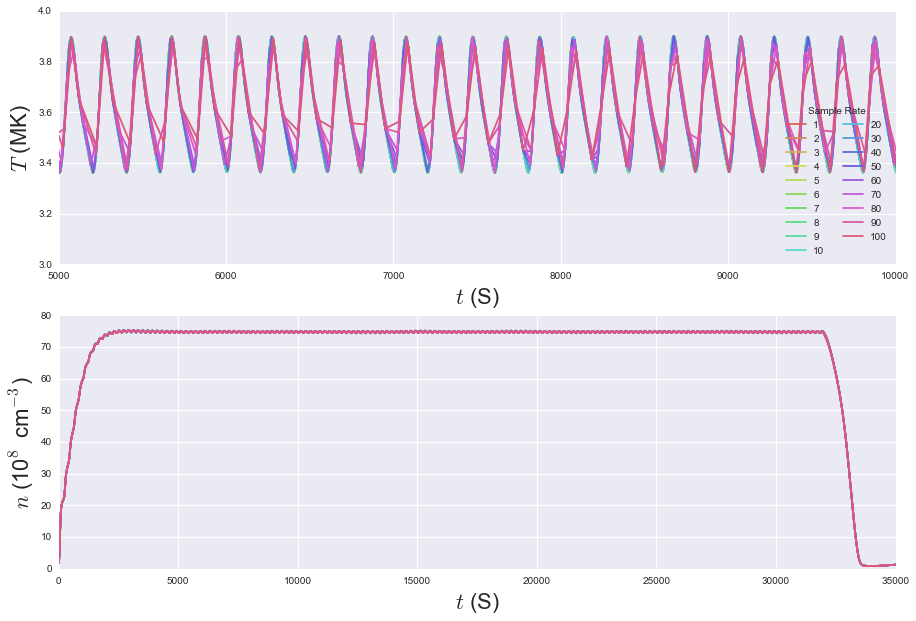

In [30]:
fig,axes = plt.subplots(2,1,figsize=(15,10))
for i in range(len(sample_rates)):
    axes[0].plot(sample_res[i][0],sample_res[i][1]/10**6,color=sns.color_palette('hls',len(sample_rates))[i],label='%d'%sample_rates[i])
    axes[1].plot(sample_res[i][0],sample_res[i][2]/10**8,color=sns.color_palette('hls',len(sample_rates))[i])
axes[0].set_xlabel(r'$t$ (S)',fontsize=22)
axes[1].set_xlabel(r'$t$ (S)',fontsize=22)
axes[0].set_ylabel(r'$T$ (MK)',fontsize=22)
axes[1].set_ylabel(r'$n$ (10$^8$ cm$^{-3}$)',fontsize=22)
axes[0].set_xlim([5000,10000])
axes[1].set_xlim([0,35000])
axes[0].set_ylim([3,4])
axes[0].legend(loc='best',ncol=2,title=r'Sample Rate')
plt.show()

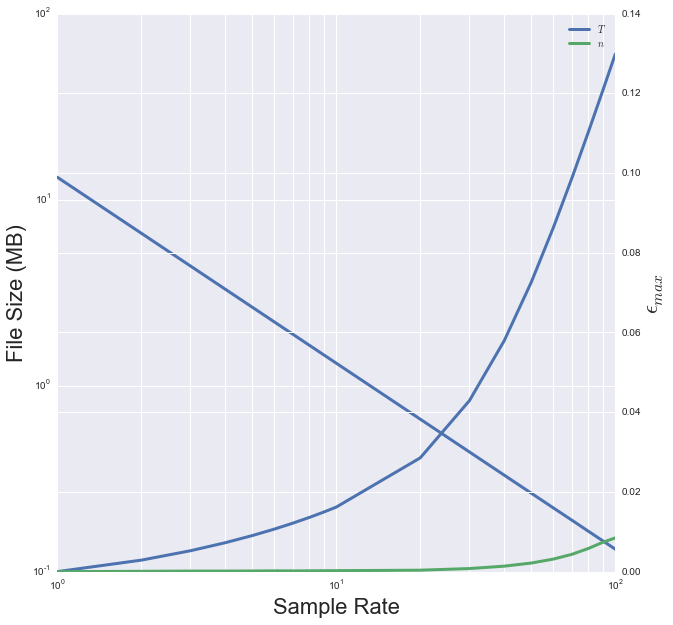

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax2 = ax.twinx()
ax.plot(sample_rates,np.array(file_size)/10**6,linewidth=3)
ax2.plot(sample_rates,error_t,linewidth=3,label=r'$T$')
ax2.plot(sample_rates,error_n,linewidth=3,label=r'$n$')
ax.set_xlabel(r'Sample Rate',fontsize=22)
ax2.set_ylabel(r'$\epsilon_{max}$',fontsize=22)
ax.set_ylabel(r'File Size (MB)',fontsize=22)
ax.set_yscale('log')
ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_xticks(sample_rates)
ax2.legend(loc='best')
plt.show()